# Imports

In [1]:
%matplotlib inline
# Core
import numpy as np
from PIL import Image
import cv2
from imageio import imwrite
import statistics as stats
import pandas as pd

import numpy as np
import lmfit
from lmfit import Model

# Visualization
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

# Image Helper Functions

In [2]:
# Showing image
def showImage(img, title1 = "Original"):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img), plt.title(title1)
  plt.show()

In [3]:
# Getting image from path
def getImage(file_path=""):
    if file_path == "":
        file_path = filedialog.askopenfilename(filetypes=[("Image Files", ".png .jpg")])
    img = cv2.imread(file_path)
    
    return img

In [4]:
# To greyscale image
def grayscale(img):
    copy = img.copy()
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    return gray

In [5]:
# Open and Close morph
def morph(img, openIter = 10, closeIter = 10):
    clean = cv2.morphologyEx(img, cv2.MORPH_OPEN, (5,5), iterations=openIter)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, (5,5), iterations=closeIter)
    return clean

# Image Processing

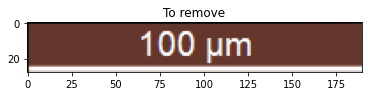

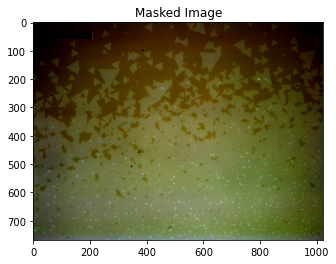

<class 'numpy.ndarray'>


In [6]:
# setting up
img = getImage("img2.png")

# finding area to mask off
showImage(img[32:60,20:210,:], "To remove")

# create mask to remove top left part
mask = np.full(img.shape[:2], 255,np.uint8)
mask[32:60,20:210] = 0
masked_img = cv2.bitwise_and(img,img,mask = mask)
showImage(masked_img, "Masked Image")

gray = grayscale(masked_img)
print(type(gray))

# Visualization

## Images

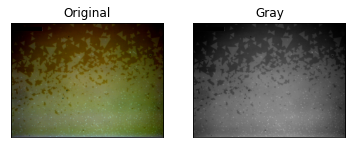

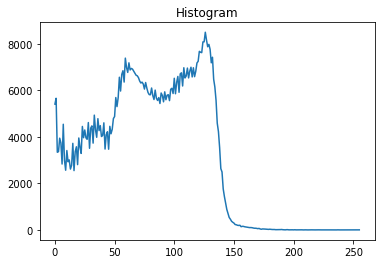

In [7]:
# showing images
plt.subplot(1,2,1), plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title("Gray"), plt.xticks([]), plt.yticks([])
plt.show()

# creating histograms of grayscaled image
histMask = cv2.calcHist([gray],[0],mask,[256],[0,256])
plt.title("Histogram")
plt.plot(histMask);plt.show()

## Intensity within a single row

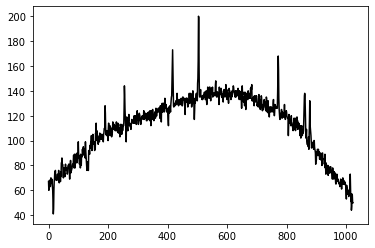

In [8]:
grayLine = gray[650,:]

plt.plot(np.arange(len(grayLine)),grayLine,"k");plt.show()

# 2D Gaussian Curve Fitting

## 2D Gaussian Function

In [9]:
def gaussian(coordinates, height ,cenX, cenY, widthX, widthY):
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    return height * np.exp(-(x-cenX)**2 / (2*widthX**2)-(y-cenY)**2 / (2*widthY**2))

## Initializing Data

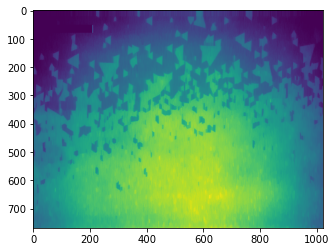

In [10]:
# initializing data arrays
morphedGray = morph(gray)
width = len(morphedGray[0])
height = len(morphedGray[:,0])

data = np.empty((width*height,3))

#widthArray = np.linspace(-width/2 , width/2, width)
#heightArray = np.linspace(-height/2 , height/2, height)

widthArray = np.arange(len(morphedGray[0]))
heightArray = np.arange(len(morphedGray[:,0]))

xx, yy = np.meshgrid(widthArray,heightArray)

data[:,0] = xx.flatten()
data[:,1] = yy.flatten()
data[:,2] = morphedGray[:,:].flatten()

originalImageArray = data[:,2].reshape(height,width)
plt.imshow(originalImageArray)

## Curve Fitting

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 786432
    # variables        = 5
    chi-square         = 87512439.4
    reduced chi-square = 111.278529
    Akaike info crit   = 3705701.15
    Bayesian info crit = 3705759.03
[[Variables]]
    height:  140.076159 +/- 0.02986183 (0.02%) (init = 1)
    cenX:    527.578010 +/- 0.08996190 (0.02%) (init = 500)
    cenY:    609.153080 +/- 0.15903421 (0.03%) (init = 300)
    widthX:  376.594878 +/- 0.12787176 (0.03%) (init = 500)
    widthY:  317.051883 +/- 0.14997282 (0.05%) (init = 500)
[[Correlations]] (unreported correlations are < 0.600)
    C(cenY, widthY) =  0.821
{'height': 140.07615882893077, 'cenX': 527.5780098301253, 'cenY': 609.1530801839643, 'widthX': 376.5948782231192, 'widthY': 317.0518831637513}


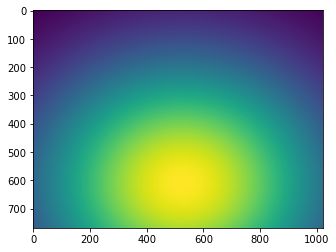

In [11]:
defaultHeight = 100
defaultCenX = 500
defaultCenY = 300
defaultWidthX = 500
defaultWidthY = 500

model = Model(gaussian)

model.set_param_hint('height', value=1, min=0, max=1000)
model.set_param_hint('cenX', value=defaultCenX, min=0, max=width)
model.set_param_hint('cenY', value=defaultCenY, min=0, max=height)
model.set_param_hint('widthX', value=defaultWidthX, min=100, max=1600)
model.set_param_hint('widthY', value=defaultWidthY, min=100, max=1600)
params = model.make_params()
result = model.fit(data[:, 2], coordinates=data[:, 0:2], params=params)
print(result.fit_report(min_correl=0.60))
print(result.best_values)
fittedArray = result.best_fit.reshape(height,width)
plt.imshow(fittedArray)

## Visualisation of Curve Fitting

In [ ]:
initFigure = plt.figure(figsize=(13, 7))
iniAxes = plt.axes(projection='3d')
initialSurface = iniAxes.plot_surface(xx, yy, data[:,2].reshape(height,width), rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
iniAxes.axes.set_zlim3d(bottom=0, top=256)
iniAxes.set_xlabel('Width')
iniAxes.invert_xaxis()
iniAxes.set_ylabel('Height')
iniAxes.set_zlabel('Intensity')
iniAxes.autoscale()
iniAxes.set_title('Intensity Plot of Original Image')
initFigure.colorbar(initialSurface, shrink=0.5, aspect=5)

iniAxes.view_init(35, 35)

In [ ]:
fittedFigure = plt.figure(figsize=(13, 7))
fittedAxes = plt.axes(projection='3d')
fittedSurface = fittedAxes.plot_surface(xx, yy, result.best_fit.reshape(height,width), rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
fittedAxes.axes.set_zlim3d(bottom=0, top=256)
fittedAxes.set_xlabel('Width')
iniAxes.invert_xaxis()
fittedAxes.set_ylabel('Height')
fittedAxes.set_zlabel('Intensity')
iniAxes.autoscale()
fittedAxes.set_title('Intensity Plot of Fitted Curve')
fittedFigure.colorbar(fittedSurface, shrink=0.5, aspect=5) 

fittedAxes.view_init(35, 35)

## Intensity within a single row

In [ ]:
row = 101
grayLine = gray[row,:]
fittedLine = fittedArray[row,:]

plt.plot(np.arange(len(grayLine)),grayLine,"k")
plt.plot(np.arange(len(fittedLine)),fittedLine,"r")


plt.show()

# Thresholding

## Adaptive Thresholding

In [ ]:
def adaptiveThresholding(img, blockSize=505, C=-2):
    gray = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize, C
    )  ########## 2 magic numbers here
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(gray,'gray')
    plt.title("OpenCV Adaptive Thresholding"), plt.xticks([]), plt.yticks([])   
    
    plt.show()
    return gray
showImage(adaptiveThresholding(gray, blockSize=505, C=0), "Adaptive Thresholding")

## Otsu Thresholding (Global)

In [ ]:
def otsuThresholding(img):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

showImage(otsuThresholding(gray),"Otsu's Thresholding (Filtered)")

## Attempt to split into subimages and apply Otsu

In [ ]:
def splitOtsu(img, splitNo, kernel):
    blur = cv2.GaussianBlur(img,kernel,0)
    height,width=img.shape[:2]
    
    for heightIndex in range(splitNo):
        for widthIndex in range(splitNo):
            heightFactor = height//splitNo
            startSplitHeight = heightIndex*heightFactor
            endSplitHeight = (heightIndex+1)*heightFactor
            
            widthFactor = width//splitNo
            startSplitWidth = widthIndex*widthFactor
            endSplitWidth = (widthIndex+1)*widthFactor
            
            ret3,th3 = cv2.threshold(blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            blur[startSplitHeight:endSplitHeight,startSplitWidth:endSplitWidth]=th3 
             
    plt.subplot(1,5,1),plt.imshow(img,'gray')
    plt.title('Original Noisy Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,2),plt.hist(img.ravel(),256)
    plt.title('Histogram'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,3),plt.imshow(th3,'gray')
    plt.title('Piece'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(1,5,5),plt.imshow(blur,'gray')
    plt.title("Split Otsu Thresholding"), plt.xticks([]), plt.yticks([])
    
    plt.show()
    
    return blur

split = 10
plt.imshow(cv2.cvtColor(splitOtsu(morph(gray,5,3),split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ") with morph")
plt.show()

plt.imshow(cv2.cvtColor(splitOtsu(gray,split,(5,5)), cv2.COLOR_BGR2RGB)), plt.title("Split Otsu Thresholding (Split: " + str(split) + ")")
plt.show()

# Correction of Image

## Subtraction Correction

In [ ]:
subCorrArray = gray - result.best_fit.reshape(height,width)
subCorrImage = subCorrArray.astype('float32')
showImage(subCorrImage, "Subtraction Correction")

In [ ]:
subCorrImage = np.stack((subCorrImage,) * 3,-1)
subCorrImage = (255-subCorrImage)
subCorrImage = subCorrImage.astype(np.uint8)
subCorrImage = cv2.cvtColor(subCorrImage, cv2.COLOR_BGR2GRAY)
showImage(otsuThresholding(subCorrImage),"Otsu Thresholding applied on Subtraction Correction")

## Divison Correction

In [ ]:
divCorrArray = gray / result.best_fit.reshape(height,width)
divCorrImage = divCorrArray.astype('float32')
showImage(divCorrImage, "Division Correction")

In [ ]:
divCorrImage = np.stack((divCorrImage,) * 3,-1)
divCorrImage = divCorrImage.astype(np.uint8)
divCorrImage = cv2.cvtColor(divCorrImage, cv2.COLOR_BGR2GRAY)
showImage(otsuThresholding(divCorrImage),"Otsu Thresholding appplied on Divion Correction")